![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Seasonal forecast download and plot for one coordinate

### About

This notebook is based on "Seasonal Forecast Anomalies": https://ecmwf-projects.github.io/copernicus-training-c3s/sf-anomalies.html
It was mainly modified to use daily resolution instead of monthly.
It provides a practical introduction to calculating seasonal forecast with data from the Copernicus Climate Change Service (C3S). C3S seasonal forecast products are based on data from several state-of-the-art seasonal prediction systems. In this tutorial we shall focus on the [ECMWF SEAS5 model](https://confluence.ecmwf.int/display/CKB/Description+of+SEAS5+C3S+contribution), which is one of the forecasting systems available through C3S.

The tutorial will demonstrate how to access real-time forecast data of total precipitation, with a forecast start date in May 2023 and 6-7 monthly lead times (up to October 2023). Hindcast data for the same start date and lead-time months in the reference period 1993 to 2016 will also be downloaded. 

The tutorial will then show how to interpolate in a coordinate for both the forecast and hindcast data. (The climate mean for the reference period will be computed and this reference mean will be subtracted from the real-time forecast data to derive monthly anomalies BORRAR?). These will be visualised as time series. Finally, 3-monthly anomalies will be calculated and visualised in an interactive plot, as a demonstration of how to reproduce similar [charts available through C3S](https://climate.copernicus.eu/charts/c3s_seasonal/).


The notebook has the following outline:
* 1 - Download data from the CDS
* 2 - Hindcast data 
* 3 - Real-time forecasts

<br>

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-postprocessed-single-levels">Precomputed anomalies are also available through the CDS</a>. Note these may be slightly different due to minor differences in the way they are computed (e.g. months of constant length, 30 days)  and also due to GRIB packing discretisation. <a href="https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ">See here for more detials.</a></div>

Please see here the full documentation of the [C3S Seasonal Forecast Datasets](https://confluence.ecmwf.int/display/CKB/C3S+Seasonal+Forecasts%3A+datasets+documentation). This notebook introduces you to the [seasonal forecast monthly statistics](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=overview) datasets on single levels (as opposed to multiple levels in the atmosphere).

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=sf-anomalies.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/sf-anomalies.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/sf-anomalies.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<hr>

### Install packages

In [ ]:
# Install CDS API for downloading data from the CDS
!pip install "cdsapi>=0.7.2"

In [ ]:
# Install cfgrib to enable us to read GRIB format files
!conda install -c conda-forge cfgrib -y
#conda update -n base -c conda-forge conda

In [27]:
# Miscellaneous operating system interfaces
import os

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import scipy

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

<hr>

## 1. Request data from the CDS programmatically with the CDS API

The first step is to request data from the Climate Data Store programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal CDS key. Please find [here](https://cds.climate.copernicus.eu/api-how-to) your personal CDS key.

In [34]:
URL = 'https://cds.climate.copernicus.eu/api'  #https://cds.climate.copernicus.eu/api'
KEY = '7c7e2544-915e-4f95-b994-8a949747cd5d'
variable_name = 'total_precipitation'
var_short = 'tp'
month_num = 12
forecast_year = 2023

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [35]:
DATADIR = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast/'

The next step is then to request the seasonal forecast daily data on single levels with the help of the CDS API. 
Below, we download two separate files of the variable for six monthly lead times.
For instance to start date in May: 
                                                                                                     **Forecasts for November 2019**

Seasonal forecast data are disseminated in the GRIB data format. Let us store the data in the main working directory with the name: 
* `ecmwf_seas5_2023_05_forecast_daily_tp.grib`.

Running the code block below will download the data from the CDS as specified by the following API keywords:

> **Format**: `Grib` <br>
> **Originating centre**: `ECMWF` <br>
> **System**: `5` *this refers to SEAS5* <br>
> **Variable**: `Total precipitation` or `2m temperature` <br>
> **Product type**: `Monthly mean` *all ensemble members will be retrieved* <br>
> **Year**: `1993 to 2016` *for the hindcast* `2023` *for the forecast* <br>
> **Month**: `5` *May* <br>
> **Leadtime month**: `1 to 6` *May to October*

If you have not already done so, you will need to accept the **terms & conditions** of the data before you can download it. These can be viewed and accepted in the [CDS download page](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=form) by scrolling to the end of the download form.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    The API request below can be generated automatically from the <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=form">CDS download page</a>. At the end of the download form there is a <code>Show API request</code> icon, which allows a copy-paste of the code below.</div>

In [36]:
c = cdsapi.Client(url=URL, key=KEY)

# Forecast data request
c.retrieve(
    'seasonal-original-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '51',
        'variable': variable_name,
        'year': forecast_year,
        'month': month_num,
        'day': '01',
        'leadtime_hour': [
            '24', '48', '72',
            '96', '120', '144',
            '168', '192', '216',
            '240', '264', '288',
            '312', '336', '360',
            '384', '408', '432',
            '456', '480', '504',
            '528', '552', '576',
            '600', '624', '648',
            '672', '696', '720',
            '744', '768', '792',
            '816', '840', '864',
            '888', '912', '936',
            '960', '984', '1008',
            '1032', '1056', '1080',
            '1104', '1128', '1152',
            '1176', '1200', '1224',
            '1248', '1272', '1296',
            '1320', '1344', '1368',
            '1392', '1416', '1440',
            '1464', '1488', '1512',
            '1536', '1560', '1584',
            '1608', '1632', '1656',
            '1680', '1704', '1728',
            '1752', '1776', '1800',
            '1824', '1848', '1872',
            '1896', '1920', '1944',
            '1968', '1992', '2016',
            '2040', '2064', '2088',
            '2112', '2136', '2160',
            '2184', '2208', '2232',
            '2256', '2280', '2304',
            '2328', '2352', '2376',
            '2400', '2424', '2448',
            '2472', '2496', '2520',
            '2544', '2568', '2592',
            '2616', '2640', '2664',
            '2688', '2712', '2736',
            '2760', '2784', '2808',
            '2832', '2856', '2880',
            '2904', '2928', '2952',
            '2976', '3000', '3024',
            '3048', '3072', '3096',
            '3120', '3144', '3168',
            '3192', '3216', '3240',
            '3264', '3288', '3312',
            '3336', '3360', '3384',
            '3408', '3432', '3456',
            '3480', '3504', '3528',
            '3552', '3576', '3600',
            '3624', '3648', '3672',
            '3696', '3720', '3744',
            '3768', '3792', '3816',
            '3840', '3864', '3888',
            '3912', '3936', '3960',
            '3984', '4008', '4032',
            '4056', '4080', '4104',
            '4128', '4152', '4176',
            '4200', '4224', '4248',
            '4272', '4296', '4320',
            '4344', '4368', '4392',
            '4416', '4440', '4464',
            '4488', '4512', '4536',
            '4560', '4584', '4608',
            '4632', '4656', '4680',
            '4704', '4728', '4752',
            '4776', '4800', '4824',
            '4848', '4872', '4896',
            '4920', '4944', '4968',
            '4992', '5016', '5040',
            '5064', '5088', '5112',
            '5136', '5160',
        ],
        'area': [
            43, 2, 42,
            3,
        ],
    },
    f'{DATADIR}/ecmwf_seas5_'+ str(forecast_year) + '_' + str(month_num) + '_forecast_daily_' + var_short + '.grib')

2025-02-16 21:13:21,974 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-16 21:13:21,974 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-16 21:13:22,921 INFO Request ID is cb5d33c1-5a3e-4dc4-a3fd-290993213f77
2025-02-16 21:13:22,996 INFO status has been updated to accepted
2025-02-16 21:13:27,976 INFO status has been updated to running
2025-02-16 21:14:38,491 INFO status has been updated to successful


7a18016efa9ef0b674d2e6899de7b18d.grib:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast//ecmwf_seas5_2023_12_forecast_daily_tp.grib'

## 2. Seasonal forecast data

The next step is to load the real-time seasonal forecast data for 6 lead time months. We will then subtract the hindcast climatology from this to derive the anomalies. 


Once the `xarray.Dataset` is loaded, you see that it has 4 dimensions:
> **Number**: 51 ensemble members <br>
> **ForecastMonth**: 6 leadtime months <br>
> **Latitude**: latitude values <br>
> **Longitude**: longitude values <br>

Compared to the hindcast data, we have only a single start date (e.g., May 2023) in the `time` coordinate. Another difference is that seasonal forecast real-time data have 51 ensemble members, compared to hindcasts, which only have 25 ensemble members.

In [17]:
#forecast_year=2019
#month_num=12

In [37]:
# Define the coordinates to interpolate to
interp_longitude=2.25 #C1=C2=2.25
interp_latitude=42.3  #C1=42.3, C2=42.05  --> SEAS5 HAS 1º RESOLUTION, SO, THE SAME VALUES ARE FOR C1 & C2

In [38]:
fore = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_'+ str(forecast_year) + '_' + str(month_num) + '_forecast_daily_' + var_short + '.grib', engine='cfgrib')

In [39]:
fore_var = fore[var_short]

#### Convert forecast lead time month into dates


In [40]:
# Interpolate the values for the specified coordinates
fore_interp = fore_var.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

In [41]:
#verify number of members
num_members = len(fore_interp)
#calculate the difference throughout the steps (215 days) to obtain daily precipitation
fore_diff = fore_interp.diff(dim='step') # by default does it along the last axis 
#Prepend the value of the original step 1 to the differences array. Otherwise the time series only has 214 steps instead of 215
first_step_value = fore_interp.isel(step=0)  # Get the value of the original step 1
# Concatenate first_step_value with subset_hind_diff along the 'step' dimension in order to obtain the 215 steps
fore_diff_with_first = xr.concat([first_step_value, fore_diff], dim='step')

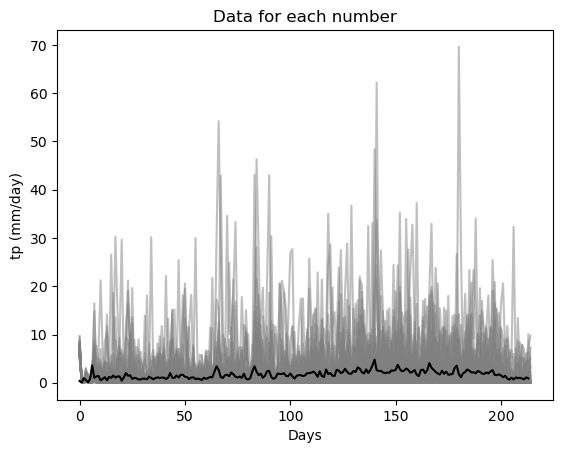

In [42]:
for i in range(num_members):
    # Select the subset of data for the current number
    subset = fore_diff_with_first.sel(number=i)*1000
    
    # Plotting
    plt.plot(subset, color='gray', alpha=0.5, label=f'Number {i}')

#plot average in black
plt.plot(fore_diff.mean(dim='number')*1000, color='black')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('tp (mm/day)')
plt.title('Data for each number')
#plt.legend()  # Add legend to differentiate lines
plt.show()


In [43]:
fore_diff_with_first.dims

('number', 'step')

## 3. Extracting data to csv files

In [44]:
#Set the path to save forecast files
save_path = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast/'

In [45]:
# Loop through each member in the 'number' dimension
for i in range(fore_diff_with_first.sizes['number']):
    # Select data for the current member and convert the value to Celsius
    member_data = fore_diff_with_first.isel(number=i)*1000
    
    # Convert to a Pandas DataFrame
    df = member_data.to_dataframe(name="value").reset_index()
    
    # Keep only the 'value' column
    df = df[['value']]
    
    # Generate a filename for the current member
    file_name = f"forecast_year{forecast_year}_month{month_num}_member{i+1}_{var_short}.csv"  # Customize naming convention if needed
    full_path = os.path.join(save_path, file_name)
    
    # Save the DataFrame to a CSV file
    df.to_csv(full_path, index=False, header=False)  # Save without index and header
    
    print(f"Saved member {i+1} to {full_path}")

Saved member 1 to C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast/forecast_year2023_month12_member1_tp.csv
Saved member 2 to C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast/forecast_year2023_month12_member2_tp.csv
Saved member 3 to C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast/forecast_year2023_month12_member3_tp.csv
Saved member 4 to C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast/forecast_year2023_month12_member4_tp.csv
Saved member 5 to C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast/forecast_year2023_month12_member5_tp.csv
Saved member 6 to C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/forecast/forecast_year2023_month12_member6_tp.csv
Saved member 7 to C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forec